In [1]:
import igraph as ig
import geopandas as gpd
import itertools as it

import numpy as np
from matplotlib import pyplot as plt

# Graph

In [2]:
g = ig.Graph(directed=True)

In [3]:
V_O = {f'RC{i+1}':i for i in range(2)}
V_O_attr = {
    'name': [e for e in V_O.keys()],
    'x': [0.5, 3.5],
    'y': [0.5, 3.5],
    'color': ['purple', 'red'],
    'type': 'res_node'
}
g.add_vertices(V_O.values(), V_O_attr)

In [4]:
V_P = {f'PT{i+1}':e for i,e in enumerate(range(2,5))}
V_P_attr = {
    'name': [e for e in V_P.keys()],
    'x': [1,3,3.4],
    'y': [1,3,3.4],
    'color': 'blue',
    'type': 'pt_node'
}
g.add_vertices(V_P.values(), V_P_attr)

In [5]:
V_D = {f'POI{i+1}':e for i,e in enumerate(range(5,6))}
V_D_attr = {
    'name': [e for e in V_D.keys()],
    'x': [2.75],
    'y': [2.75],
    'color': 'green',
    'type': 'poi_node'
}
g.add_vertices(V_D.values(), V_D_attr)

## PTN Edges

In [6]:
# Speeds
WALKING_SPEED = 5  # units per hour
BUS_SPEED = 100  # units per hour
TRAIN_SPEED = 1000  # units per hour

In [7]:
def compute_dist_from_es(es: list):
    positions = [(g.vs[e[0]]['x'], g.vs[e[0]]['y'], g.vs[e[1]]['x'], g.vs[e[1]]['y']) for e in es]
    pos_arr = np.array(positions)
    return np.sqrt((pos_arr[:,[0,2]].max(axis=1)-pos_arr[:,[0,2]].min(axis=1))**2+
                   (pos_arr[:,[1,3]].max(axis=1)-pos_arr[:,[1,3]].min(axis=1))**2)

### Walking

In [8]:
E_WALK = list(it.product(V_O.values(),V_P.values())) +\
         list(it.product(V_P.values(), V_D.values())) +\
         list(it.product(V_O.values(), V_D.values()))
distances_walk = compute_dist_from_es(E_WALK)
E_WALK_attr = {
    'distance': distances_walk,
    'tt': (distances_walk * 1/WALKING_SPEED) * 60,
    'weight': (distances_walk * 1/WALKING_SPEED) * 60,
    'color': 'gray',
    'type': 'walk',
}
g.add_edges(E_WALK, E_WALK_attr)

### PT

In [9]:
E_BUS = [
    (V_P['PT1'],V_P['PT2']),  # Bus_line_1
    (V_P['PT2'],V_P['PT1']),  # Bus_line_1
    (V_P['PT2'],V_P['PT3']),  # Bus_line_2
    (V_P['PT3'],V_P['PT2']),  # Bus_line_2
]
distances_bus = compute_dist_from_es(E_BUS)
E_BUS_attr = {
    'name': list(it.repeat(f'Bus_line_1',2)) +
            list(it.repeat(f'Bus_line_2',2)),
    'distance': distances_bus,
    'tt': (distances_bus * 1/BUS_SPEED) * 60,
    'weight': (distances_bus * 1/BUS_SPEED) * 60,
    'color': 'pink',
    'type': 'bus',
}
g.add_edges(E_BUS, E_BUS_attr)

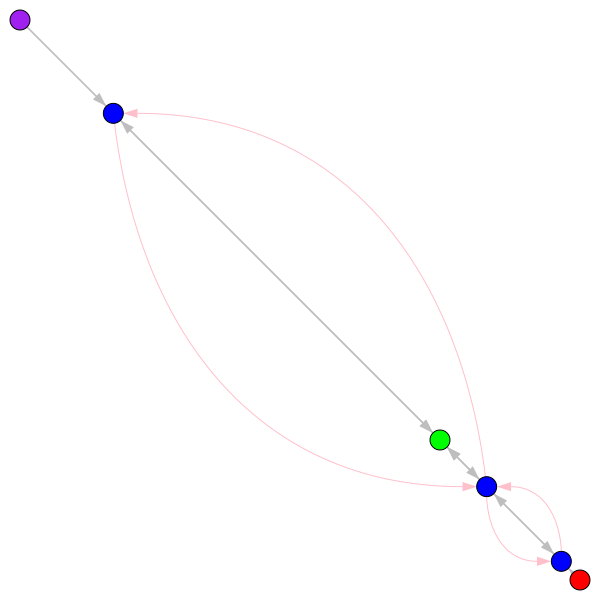

In [10]:
# fig, ax = plt.subplots(figsize=(5,5))
ig.plot(g, target='plots/synthetic_graphs/synthetic_graph_1.svg')

In [11]:
g.es['active'] = 1

In [12]:
g.save('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_1/graph.gml')
g.save('/home/rico/Documents/thesis/experiments/base_data/graph_1.gml')

# Census Data

In [13]:
data = {
    'neighborhood': V_O_attr['name'],
    'n_inh': [1000,100],
    'n_purple': [1000,0],
    'n_red': [0,100],
    'res_centroids': gpd.points_from_xy(V_O_attr['x'], V_O_attr['y'])
}

gdf = gpd.GeoDataFrame(data, geometry='res_centroids')
gdf

,neighborhood,n_inh,n_purple,n_red,res_centroids
0,RC1,1000,1000,0,POINT (0.50000 0.50000)
1,RC2,100,0,100,POINT (3.50000 3.50000)


In [14]:
gdf.to_file('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_1/census_data.geojson', driver='GeoJSON')
gdf.to_file('/home/rico/Documents/thesis/experiments/base_data/census_data_1.geojson', driver='GeoJSON')

/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Plotting

In [15]:
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

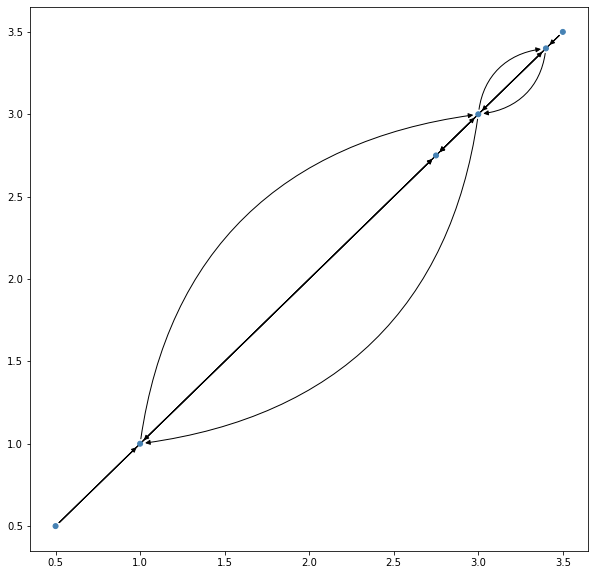

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ig.plot(g, target=ax)
# ax = fig.add_subplot(111)
# rect = [0.1,0.1,0.2,0.2]
# ax1 = add_subplot_axes(ax,rect)
plt.show()

In [17]:
ax = ig.plot(g)

In [18]:
# ax.save('plots/synthetic_graphs/synthetic_graph_0.png')

In [19]:
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

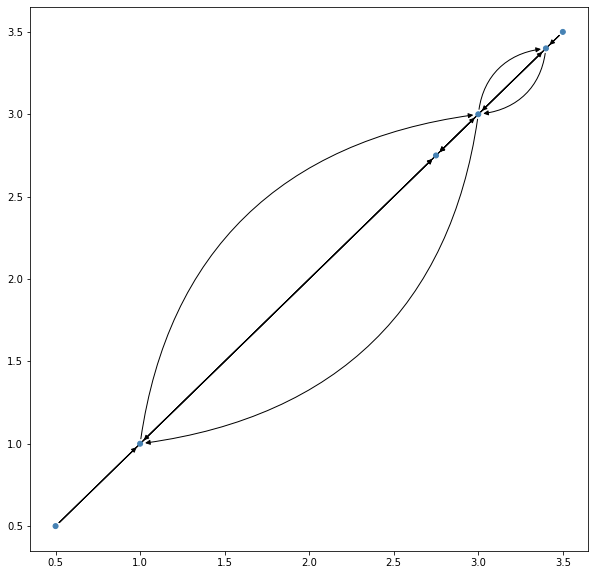

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
ig.plot(g, target=ax)
# ax = fig.add_subplot(111)
# rect = [0.1,0.1,0.2,0.2]
# ax1 = add_subplot_axes(ax,rect)
plt.show()

In [21]:
ax = ig.plot(g)

In [22]:
# ax.save('plots/synthetic_graphs/synthetic_graph_0.png')